<a href="https://colab.research.google.com/github/kusawokoshitemori/MachineLearningPractice/blob/main/MachineLearningPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
pip install keras-tuner --upgrade


In [54]:
# ハーパーパラメーターの選定に使用
import keras_tuner
import keras

In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNISTデータを取得
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 訓練データを10000枚に制限
train_images = train_images[:10000]
train_labels = train_labels[:10000]

# 画像を表示
# plt.imshow(train_images[0], cmap="gray")
# plt.title(f"Label: {train_labels[0]}")
# plt.show()


In [56]:
# 画像データを0〜1に正規化 MLP使う場合
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# 画像データを0〜1に正規化 CNN使用する場合(白黒画像だから1)
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0


In [57]:
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels, num_classes=10)
# test_labels = to_categorical(test_labels, num_classes=10)


In [58]:
from tensorflow.keras import models, layers, regularizers

# モデルの関数化
def build_model(hp):
    model = keras.Sequential()

    # 1つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=hp.Int("filters_1", min_value=32, max_value=128, step=32),
        kernel_size=3, activation="relu", input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # 2つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=hp.Int("filters_2", min_value=64, max_value=256, step=64),
        kernel_size=3, activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # 3つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=hp.Int("filters_3", min_value=128, max_value=512, step=128),
        kernel_size=3, activation="relu"
    ))

    # Flattenして全結合層へ
    model.add(layers.Flatten())

    # 隠れ層（ユニット数はハイパーパラメータ）
    model.add(layers.Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01)
    ))

    # Dropout（過学習防止）
    model.add(layers.Dropout(0.3))

    # 出力層
    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [59]:
from tensorflow.keras.utils import to_categorical

# ラベルを one-hot エンコーディングに変換
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)


In [61]:
from kerastuner.tuners import RandomSearch

# 新しいチューナーを作成
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,  # 5回の試行
    executions_per_trial=1,
    directory="my_tuner",  # 変更すると履歴がリセットされる
    project_name="mnist_cnn"
)

# 以前の結果が残らないように削除
import shutil
shutil.rmtree("my_tuner", ignore_errors=True)  # フォルダを削除

# 再度チューニング
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

# 最適なモデルを取得
best_model = tuner.get_best_models()[0]


Trial 5 Complete [00h 00m 23s]
val_loss: 0.046092383563518524

Best val_loss So Far: 0.044670235365629196
Total elapsed time: 00h 01m 55s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
# モデルの構造を表示
best_model.summary()

# テストデータで評価
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 288)                 │         663,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405,162 (5.36 MB)

 Trainable params: 1,405,162 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9826 - loss: 0.0558
Test accuracy: 0.9856


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9899 - loss: 0.0315 - val_accuracy: 0.9852 - val_loss: 0.0504
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9939 - loss: 0.0198 - val_accuracy: 0.9790 - val_loss: 0.0757
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9944 - loss: 0.0176 - val_accuracy: 0.9854 - val_loss: 0.0619
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9964 - loss: 0.0119 - val_accuracy: 0.9688 - val_loss: 0.1307
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9909 - loss: 0.0298 - val_accuracy: 0.9879 - val_loss: 0.0470
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9879 - val_loss: 0.0534
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.9752 - val_loss: 0.1111
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0

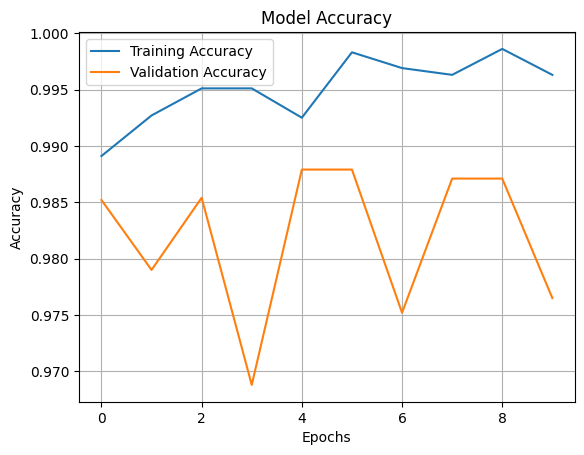

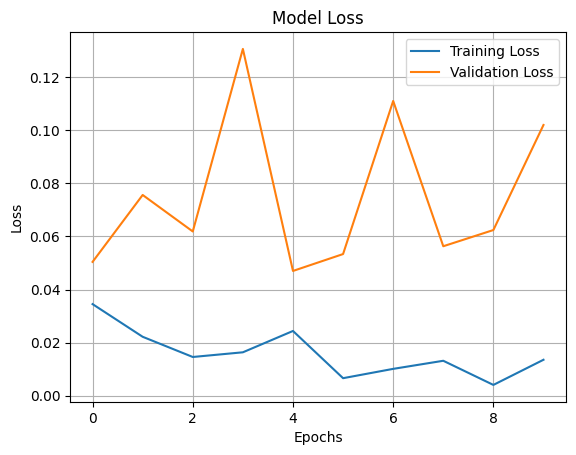

In [63]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStoppingの設定
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# すでにコンパイル済みなら、再コンパイルは不要
# best_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# best_model の再学習
hist = best_model.fit(train_images, train_labels,
                      epochs=50,
                      validation_data=(test_images, test_labels),
                      callbacks=[early_stopping])

# 学習結果の可視化
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# import numpy as np

# # 学習後、最初の1つのデータに対して予測
# predictions = model(train_images[:3]).numpy()

# # ソフトマックスで確率に変換
# probabilities = tf.nn.softmax(predictions)

# # 確率をNumPy配列に変換
# probabilities_np = probabilities.numpy()

# # NumPyでの表示設定を変更
# np.set_printoptions(precision=3, suppress=True)

# # 確率を表示
# print(probabilities_np)

# print(train_labels[:3])

In [ ]:
# import numpy as np

# # 学習後、最初の1つのデータに対して予測
# predictions = model(test_images[:3]).numpy()

# # ソフトマックスで確率に変換
# probabilities = tf.nn.softmax(predictions)

# # 確率をNumPy配列に変換
# probabilities_np = probabilities.numpy()

# # NumPyでの表示設定を変更
# np.set_printoptions(precision=3, suppress=True)

# # 確率を表示
# print(probabilities_np)

# print(test_labels[:3])

In [64]:
# 訓練データ
train_loss, train_acc = best_model.evaluate(train_images, train_labels)
print("Train accuracy:", train_acc)



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0016
Train accuracy: 0.9995999932289124


In [65]:
# テストデータ
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0551
Test accuracy: 0.9879000186920166
